In [1]:
import keras, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, tqdm
import os.path
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
import sklearn, sklearn.model_selection

In [3]:
datadir = os.path.join(os.path.expanduser('~'), 'data2', 'behavioralCloning')

In [4]:
data = np.load(os.path.join(datadir, 'multiData-mouseForwardFuller.npz'))
X = data['X']
Y = data['Y'][:, 0].reshape(-1, 1)

In [5]:
modelname = 'inceptionv3_deeper_wider-mouseForwardFuller-tanh-normalInput'

In [6]:
X.shape, Y.shape

((12000, 160, 320, 3, 3), (12000, 1))

In [56]:
# steering, throttle, brake = Y.T

# fig, ax = plt.subplots()
# alpha = .6
# bins = 64
# ax.hist(steering, bins=bins, alpha=alpha, label='steering');
# # ax.hist(throttle, bins=bins, alpha=alpha, label='throttle');
# # ax.hist(brake, bins=bins, alpha=alpha, label='brake');
# ax.legend()
# ax.set_xlabel('values')
# ax.set_ylabel('counts')


In [9]:
# %%time
# X_train, X_valid, Y_train, Y_valid = sklearn.model_selection.train_test_split(center, Y)
# X_valid, X_test, Y_valid, Y_test = sklearn.model_selection.train_test_split(X_valid, Y_valid)
# X_train.shape, X_valid.shape, X_test.shape

In [57]:
# center = X[..., 0]
# print(center.shape)
# fig,ax=plt.subplots(figsize=(2,1));
# ax.imshow(center[0])
# ax.set_xticks([]); ax.set_yticks([]);

In [10]:
def prod(it):
    out = 1
    for x in it:
        try:
            out *= float(x)
        except TypeError:
            out *= int(x)
    return out

In [11]:
%%time
def VGG(
    nout=1, input_shape=center.shape[1:], doCompile=True, 
    loss='mse', optimizer='nadam', metrics=['accuracy', 'mae'],
    ):
    
    # Normalize.
    x = keras.layers.Input(input_shape)
    x = keras.layers.Lambda(lambda y: (y / 255.0) - 0.5)(x)
    
    model = keras.applications.inception_v3.InceptionV3(
        include_top=False, 
        weights='imagenet', 
        input_tensor=x,
        #input_shape=input_shape, 
        #pooling=None, 
        #classes=1000
    )
    img_input = model.layers[0].input
    nUnfrozen = sum([prod(w.shape) for w in model.trainable_weights])
    for layer in model.layers:
        layer.trainable = False
    
    # Get flattened output.
    x = model.layers[-1].output
    print('Pretrained model provides {:,} features.'.format(prod(x.shape[1:])))
    x = keras.layers.Flatten()(x)
    
    
    # Add layers.
    init = dict(bias_initializer='zeros', kernel_initializer='glorot_normal')
    x = keras.layers.Dense(16, activation='relu', **init)(x)
#     for k in range(3):
#         x = keras.layers.Dense(16, activation='relu', **init)(x)
#     x = keras.layers.Dense(16, activation='tanh', name='tanh')(x)
#     x = keras.layers.Dense(nout, activation='linear', name='predictions')(x)
    for k in range(4):
        x = keras.layers.Dense(16, activation='relu', **init)(x)
    x = keras.layers.Dense(nout, activation='tanh', name='tanh')(x)
    
    model = keras.Model(inputs=img_input, outputs=x)
    
    nFrozen = sum([prod(w.shape) for w in model.trainable_weights])
    print("Freezing reduces trainable size from {:,} to {:,} parameters.".format(nUnfrozen, nFrozen))
    
    if doCompile:
        model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=metrics,
        )
    return model

model = VGG(
    optimizer=keras.optimizers.Nadam(
        lr=0.0001, #beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    )
)


Pretrained model provides 49,152 features.
Freezing reduces trainable size from 21,768,352 to 787,553 parameters.
CPU times: user 4.66 s, sys: 140 ms, total: 4.8 s
Wall time: 12.4 s


In [13]:
class TqdmCallback(keras.callbacks.Callback):
    def __init__(self, nbatch):
        self.pbar = tqdm.tqdm_notebook(total=nbatch, unit='epoch')
    
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        self.pbar.update()

In [14]:
NEPOCH = 32

In [15]:
log_dir = '/home/tsbertalan/tensorboardlogs/behavClon/%s-%s/'% (modelname, time.time())

In [16]:
%%time
history = model.fit(
    center, Y,
    validation_split=.2,
    #X_train, Y_train, 
    #validation_data=(X_valid, Y_valid), 
    epochs=NEPOCH,
    callbacks=[
        TqdmCallback(NEPOCH),
        keras.callbacks.TensorBoard(
            log_dir=log_dir,
            #batch_size=32, 
            write_graph=True, 
        ),
    ],
    verbose=0
)

A Jupyter Widget

CPU times: user 16min 49s, sys: 30.6 s, total: 17min 20s
Wall time: 22min 3s


In [17]:
%%time
fpath = os.path.join(datadir, '%s.h5' % modelname)
print('Saving to', fpath)
model.save(fpath)

Saving to /home/tsbertalan/data2/behavioralCloning/inceptionv3_deeper_wider-mouseForwardFuller-tanh-normalInput.h5
CPU times: user 3.06 s, sys: 88 ms, total: 3.14 s
Wall time: 3.64 s


In [18]:
!recent /home/tsbertalan/data2/behavioralCloning/ | head -n 4


total 18G
-rwxrwxrwx 1 tsbertalan tsbertalan  94M Nov 13 14:05 inceptionv3_deeper_wider-mouseForwardFuller-tanh-normalInput.h5
-rwxrwxrwx 1 tsbertalan tsbertalan 5.2G Nov 13 13:38 multiData-mouseForwardFuller.npz
-rwxrwxrwx 1 tsbertalan tsbertalan  94M Nov 13 12:54 inceptionv3_deeper_wider-mouseForwardFull-tanh-normalInput.h5


In [19]:
pred = model.predict(center)
pred.shape

(12000, 1)

In [29]:
def runningMeanFast(x, N):
    return np.convolve(x.ravel(), np.ones((N,))/N)[(N-1):]

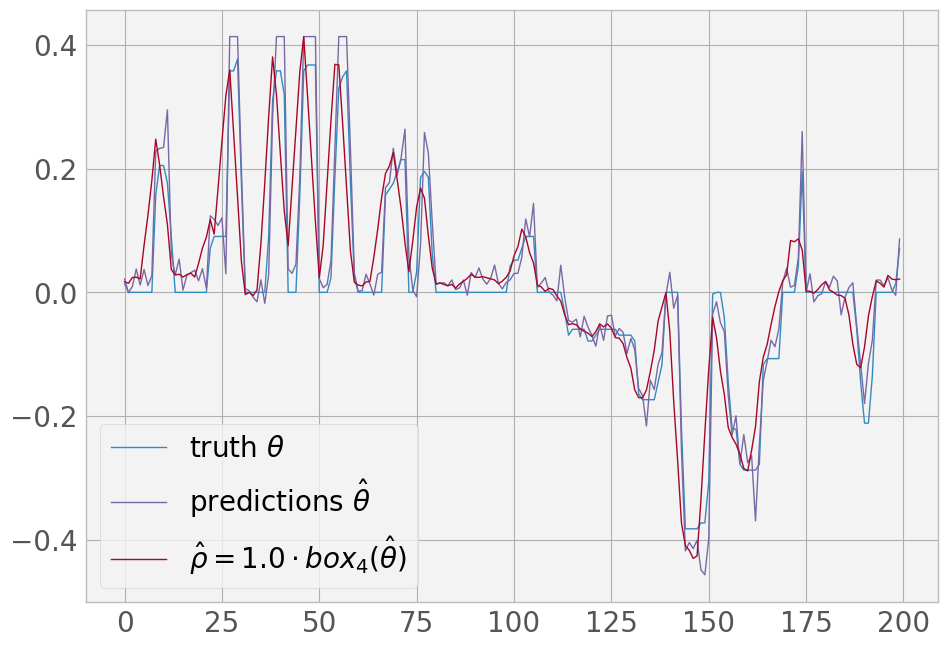

In [54]:
fig, ax = plt.subplots()
start = 1450
end = start + 200
ax.plot(Y[start:end, 0], label=r'truth $\theta$')
ax.plot(pred[start:end], label=r'predictions $\hat\theta$')
filtersize = 4
scale = 1
ax.plot(
    scale * runningMeanFast(pred[start:end], filtersize), 
    label=r'$\hat\rho = %.1f \cdot box_{%d}(\hat\theta)$' % (scale, filtersize)
)
ax.legend();